In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

from analysis import plot # imoporting analysis module enables import from model folder
from build_input import get_stim_cycle, t_start, on_time, off_time

TRIAL_NAME = "long_47"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

isbaseline = 'baseline' in TRIAL_NAME or 'const' in TRIAL_NAME

### LFP

In [2]:
elec_id = 0
ecp_file = "ecp.h5"

with h5py.File(os.path.join(TRIAL_PATH, ecp_file), 'r') as f:
    ecp = f['ecp']
    lfp = ecp['data'][:, elec_id]
    lfp -= np.mean(lfp)
    t = np.arange(*ecp['time'])
    fs = 1000 / ecp['time'][2] # sampling rate Hz

In [3]:
if isbaseline:
    on_time, off_time = on_time + off_time, 0.0
else:
#     # if any correction needed
#     t_start = 1.25  # sec. Time to start burst input
#     on_time = 0.75  # sec. Burst input duration
#     off_time = 0.75  # sec. Silence duration
    t_stop = t.size / fs
    t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)
    window = t_start + np.array([[0, on_time]])
    windows = (window + t_cycle * np.arange(n_cycle).reshape(n_cycle, 1))

tseg = 0.5
f, pxx, stim_cycle = plot.get_psd_on_stimulus(
    lfp, fs, on_time, off_time, t_start, t=t, tseg=tseg)

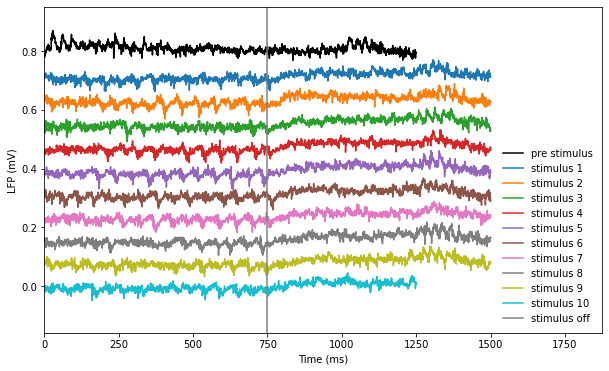

In [4]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.plot_stimulus_cycles(t, lfp, stim_cycle, dv_n_sigma=5., var_label='LFP (mV)', ax=ax)
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 600 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -5.1310, 1.0055                                          
                                                                                                  
                                       10 peaks were found:                                       
          

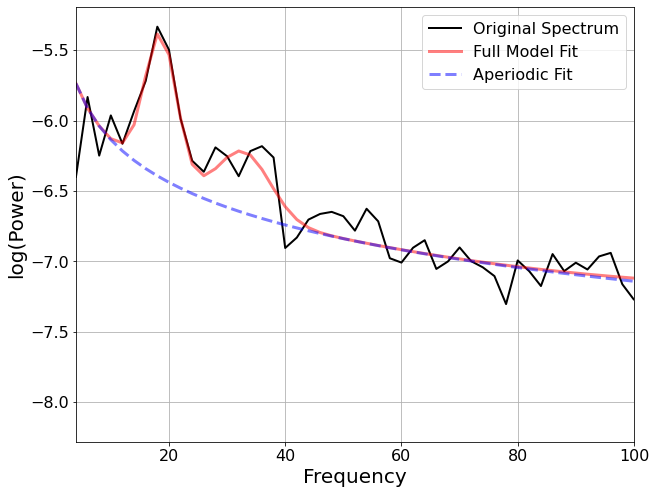

In [5]:
plt_range = 100.
plt_log=False

results, fm = plot.fit_fooof(
    f, pxx, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
    freq_range=600., peak_width_limits=100., report=True,
    plot=True, plt_log=plt_log, plt_range=plt_range)

save_fooof = False
if save_fooof:
    SAVE_PATH = os.path.join(TRIAL_PATH, 'FOOOF_results')
    fm.save(SAVE_PATH, save_results=True, save_settings=True, save_data=True)

    # Save out a report of the current model fit & results
    REPORT_PATH = os.path.join(TRIAL_PATH, 'FOOOF_report')
    fm.save_report(REPORT_PATH, plt_log=plt_log)

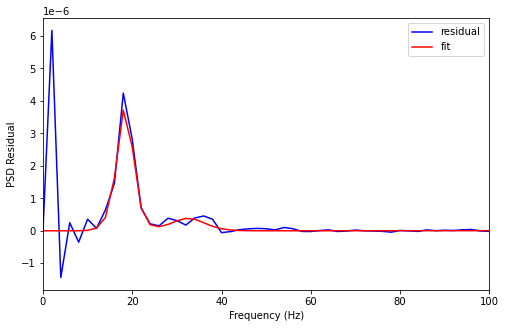

In [6]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
res_psd, res_fit = plot.psd_residual(
    f, pxx, results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
yl = plt.gca().get_ylim()
plt.gca().set_ylim(bottom=max(yl[0], -yl[1]))
plt.show()

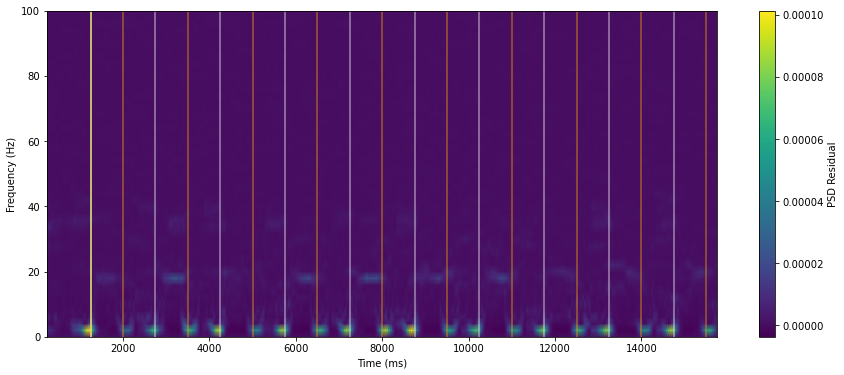

In [7]:
# %matplotlib notebook

tres = 0.05 # sec. time resolution
plt_log=False

_, ax = plt.subplots(1, 1, figsize=(15, 6))
_ = plot.plot_spectrogram(lfp, fs, tseg, tres=tres, remove_aperiodic=results,
                          plt_log=plt_log, plt_range=plt_range, ax=ax)
ax.axvline(t_start * 1000, color='y', label='pre stimulus')
if not isbaseline:
    for win in windows:
        ax.axvline(win[0] * 1000, color='white', alpha=0.5)
        ax.axvline(win[1] * 1000, color='orange', alpha=0.5)
plt.show()

### Spike rate

In [8]:
%matplotlib inline

spike_file = "spike_rate.h5"

with h5py.File(os.path.join(TRIAL_PATH, spike_file), 'r') as f:
    t_spk = np.arange(*f['time'])
    fs_spk = 1000 / f['time'][2] # sampling rate Hz
    pop_rspk = {p: g['data'][()] for p, g in f['populations'].items()}
    pop_num = {p: g.attrs['number'] for p, g in f['populations'].items()}

In [9]:
spike_groups = [['CP', 'CS'], ['FSI'], ['LTS']]
group_label = [' + '.join(spk_grp) for spk_grp in spike_groups]
spike_rate = []
for grp in spike_groups:
    rspk = np.zeros_like(t_spk)
    num = 0
    for p in grp:
        rspk += pop_rspk[p]
        num += pop_num[p]
    rspk *= fs / num
    rspk -= rspk.mean()
    spike_rate.append(rspk if np.any(rspk) else None)

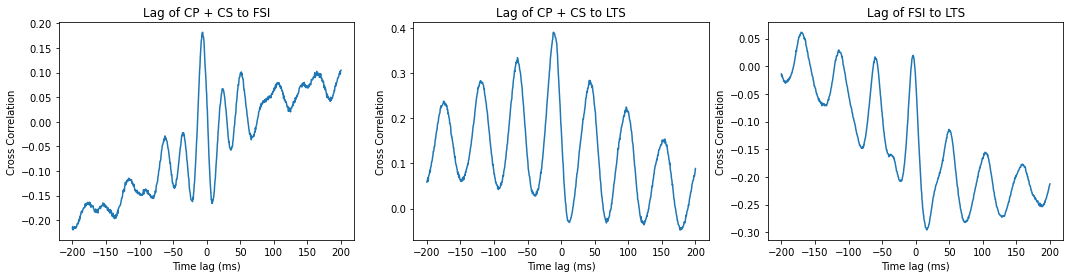

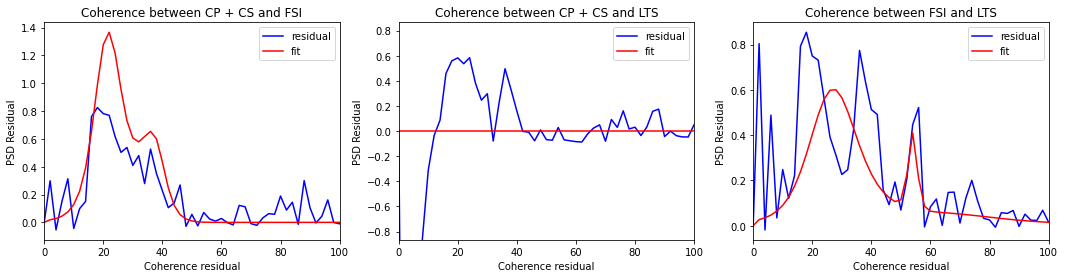

In [10]:
grp_pairs = [[0, 1], [0, 2], [1, 2]]
max_lag = 200. # ms
ngrps = len(grp_pairs)
i_start = int(t_start * fs_spk)

_, axs1 = plt.subplots(1, ngrps, figsize=(6 * ngrps, 4))
_, axs2 = plt.subplots(1, ngrps, figsize=(6 * ngrps, 4))

for i, grp_pair in enumerate(grp_pairs):
    if spike_rate[grp_pair[0]] is None or spike_rate[grp_pair[1]] is None:
        continue
    rspk1, rspk2 = spike_rate[grp_pair[0]][i_start:], spike_rate[grp_pair[1]][i_start:]

    xcorr, xcorr_lags = plot.xcorr_coeff(rspk1, rspk2, dt=1000 / fs_spk, max_lag=max_lag, ax=axs1[i])
    axs1[i].set_xlabel('Time lag (ms)')
    axs1[i].set_title('Lag of %s to %s' % (group_label[grp_pair[0]], group_label[grp_pair[1]]))

    f, cxy = plot.get_coh_on_stimulus(spike_rate[grp_pair[0]], spike_rate[grp_pair[1]],
                                      fs_spk, on_time, off_time, t_start, t=t_spk, tseg=tseg)

    coh_results, fm = plot.fit_fooof(
        f, cxy, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=600., peak_width_limits=100, report=False,
        plot=False, plt_range=plt_range, figsize=(8, 4))

    res_psd, res_fit = plot.psd_residual(
        f, cxy, coh_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=axs2[i])
    axs2[i].set_title('Coherence between %s and %s' % (group_label[grp_pair[0]], group_label[grp_pair[1]]))
    axs2[i].set_xlabel('Coherence residual')
    yl = axs2[i].get_ylim()
    axs2[i].set_ylim(bottom=max(yl[0], -yl[1]))
plt.show()

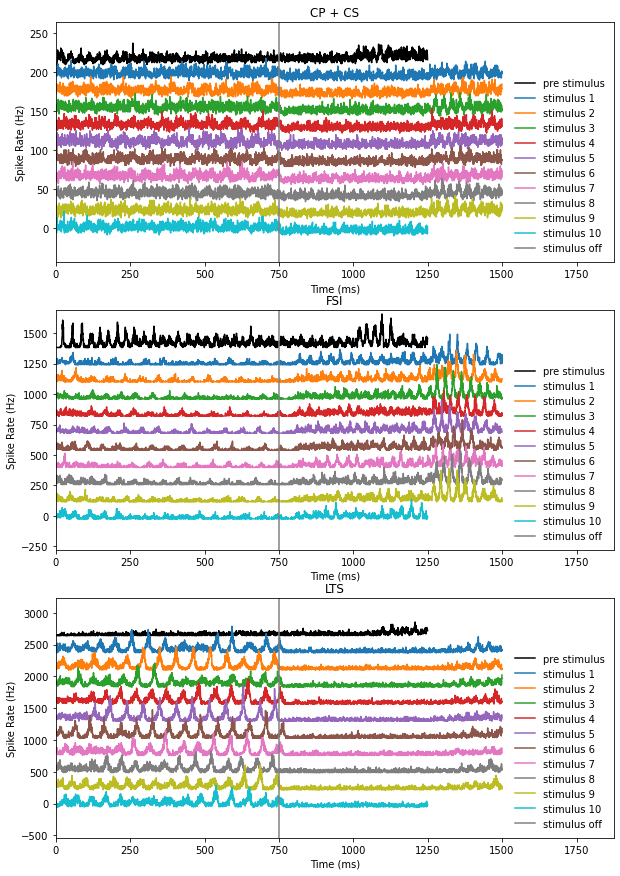

In [11]:
# %matplotlib notebook

spk_psd = []
_, axs = plt.subplots(3, 1, figsize=(10, 15))
for i, rspk in enumerate(spike_rate):
    if rspk is None:
        spk_psd.append(None)
        continue
    f, spk_pxx, stim_cycle = plot.get_psd_on_stimulus(
        rspk, fs_spk, on_time, off_time, t_start, t=t_spk, tseg=tseg)
    spk_psd.append(spk_pxx)
    plot.plot_stimulus_cycles(t_spk, rspk, stim_cycle, dv_n_sigma=5., var_label='Spike Rate (Hz)', ax=axs[i])
    axs[i].set_title(group_label[i])
plt.show()

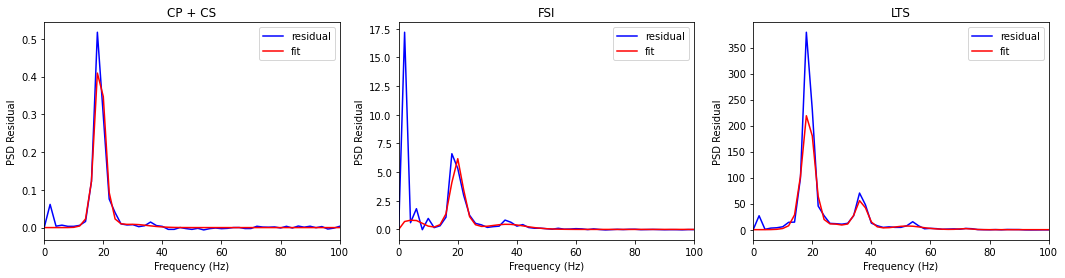

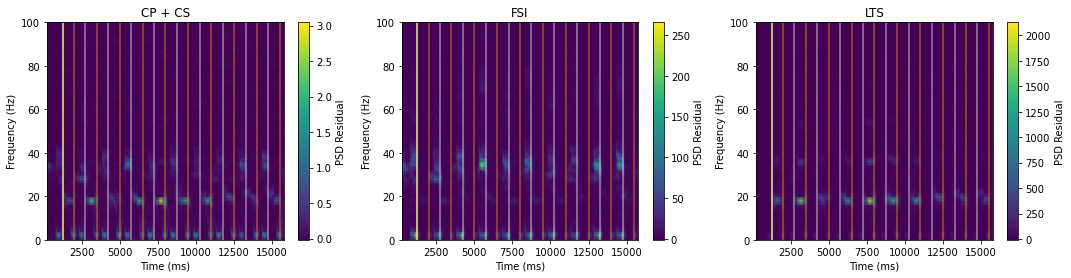

In [12]:
%matplotlib inline
# %matplotlib notebook

_, axs3 = plt.subplots(1, ngrps, figsize=(6 * ngrps, 4))
_, axs4 = plt.subplots(1, ngrps, figsize=(6 * ngrps, 4))
for i, spk_pxx in enumerate(spk_psd):
    if spk_pxx is None:
        continue
    spk_results, fm = plot.fit_fooof(
        f, spk_pxx, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=500., peak_width_limits=100, report=False, plot=False)
    res_psd, res_fit = plot.psd_residual(
        f, spk_pxx, spk_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=axs3[i])
    axs3[i].set_title(group_label[i])
    yl = axs3[i].get_ylim()
    axs3[i].set_ylim(bottom=max(yl[0], -yl[1]))

    _ = plot.plot_spectrogram(spike_rate[i], fs_spk, tseg, tres=tres, remove_aperiodic=spk_results,
                              plt_log=plt_log, plt_range=plt_range, ax=axs4[i])
    axs4[i].set_title(group_label[i])
    axs4[i].axvline(t_start * 1000, color='y', label='pre stimulus')
    if not isbaseline:
        for win in windows:
            axs4[i].axvline(win[0] * 1000, color='white', alpha=0.5)
            axs4[i].axvline(win[1] * 1000, color='orange', alpha=0.5)
plt.show()